# Varia

In this chapter we will look into couple different architectures, saliency and other tricks, which did not found their own chapters. Each section will have open-ended task for you to experiment with.

In [2]:
import pickle
import gzip
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from IPython import display
from time import sleep
from PIL import Image

## Transfer Learning

Since lower level features in networks for image tasks turn out to be quite basic we can transfer this knowledge to new datasets by training only later layers.

<img width=50% src="https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png">

For example let's take MobileNet pre-trained on imagenet and chop it's end. 

In [3]:
# Default input is 32x32x3, it might de different in your application
mobile_net = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Let's fix those weights
for layer in mobile_net.layers:
    layer.trainable = False
    
# Adding new trainable Dense layers
inputs = keras.layers.Input(shape=(32, 32, 3))
# Note that we might need to upsample our images if they are too small (less than 32x32), this is done via:
# inputs = keras.layers.UpSampling2D((2, 2))(inputs)
embedding = mobile_net(inputs)
# Output shape for sure is problem dependant, but this should give you the idea
output = keras.layers.Flatten()(embedding)
output = keras.layers.Dense(10, activation='softmax')(output)
# Build the model
model = keras.models.Model(inputs=inputs, outputs=output)
model.summary()

Metal device set to: Apple M1


2022-11-23 13:54:58.575500: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-23 13:54:58.575710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
Total params: 3,239,114
Trainable params: 10,250
Non-trainable params: 3,228,864
_________________________________________________________________


Note the number of trainable parameters. For sure it's possible to update original weights too, but fixing them is a usually a good starting point.

**TASK:** try to train last layers of this net on Fashion MNIST dataset. Note, that MobileNet requires 3 color channels and different input shape.

## Saliency

There is the myth that NN's are hard to interpret and there is no clear way to interpret feature importance. It turns out that this is quite easy and we can use backpropagation itself for that. Think about the maning of the abosulte value of $\frac{d_{out}}{d_{input}}$. This value will be high for features which are highly contributing for the output! We will implement this idea using GradientTape.

Gradients can be calculated in TensorFlow using GradientTape, for example:

```python
x = tf.Variable(3.0)
with tf.GradientTape() as tape:
    y = x**2
tape.gradient(y, x)
```

will calculate $\frac{dy}{dx}$ at point $3$, thus yielding $6$.

In [110]:
def saliency(model, single_input):
    single_input = tf.convert_to_tensor(single_input, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(single_input)
        predictions = model(single_input)
        winning_class = tf.argmax(predictions, axis=1)[0]
        output = predictions[:, winning_class]

    # Gradients of the loss with respect to the input
    gradient = tape.gradient(output, single_input)

    return np.abs(gradient)

To test this out let's make a simple dataset where *y* is averate of first two columns and third column is not used.

In [122]:
X = np.random.normal(size=(1000, 3))
y = (X[:, 0] / 2 + X[:, 1]) / 2

Now let's fit simple regression NN and look at salience.

In [123]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(5, activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(loss='mse')

model.fit(X, y, epochs=50, verbose=0)

2022-11-23 15:21:48.733615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


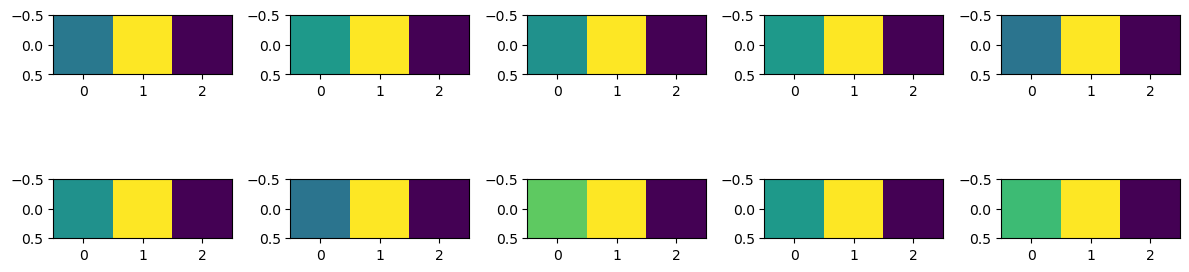

In [124]:
plt.figure(figsize=(12, 4))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(saliency(model, X[[i]]))

plt.tight_layout()
plt.show()

Nice, nearly all value comes from first two features, exactly as expected. If you will increase epoch count and overfit train data weights should even up (try that).

**TASK:** take your own flatland model and visualize salience.

In [ ]:
FCN (Dense)
CNN
Attention

## Architectures

There are a lot of possible architectures, we have only touched the surface. Take a glympse at the variations of Neural Networks [here](https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464).

<img src="https://miro.medium.com/max/2000/1*cuTSPlTq0a_327iTPJyD-Q.png" style="width: 80%"/>

### Autoencoders

Autoencoders try to squeeze data by having a bottleneck layer (see viz above). Using Autoencoders we can easily replicate SVD and PCA. And as you know this can be used in data compression, recommenders, outlier detectors etc. Not only that NN's allow to make much richer autoencoders, thus improving quality.

Let's go back to a part of SVD lecture and try to compress image using NN.

In [125]:
def plot(X):
    """Just a little helper function to get a nice image plot"""
    m = 255 if X.max() > 200 else 1
    plt.imshow(X, cmap='gray', vmin=0, vmax=m)
    plt.axis('off')

In [8]:
!curl https://raw.githubusercontent.com/trokas/ai_primer/master/img/castle.jpg --output castle.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9217  100  9217    0     0  21915      0 --:--:-- --:--:-- --:--:-- 22263


Image shape (312, 198)


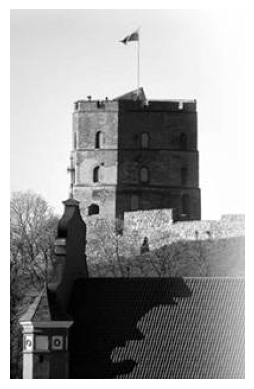

In [126]:
img = Image.open('castle.jpg')
img.load()
X = np.asarray(img, dtype="int32")
print(f'Image shape {X.shape}')
plot(X)

As you might remember we did compression using SVD.

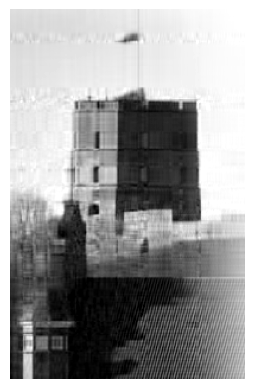

In [131]:
N = 20    # Compression

U, S, V = np.linalg.svd(X)
plot((U[:,:N] * S[:N]).dot(V[:N]))

Before training NN, let's scale down and center our inputs. Scaling this time is important!

In [132]:
X = X.astype('float32') / 255.
means = X.mean(axis=0)
X = X - means

In [134]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(100, activation='relu'))
...
model.add(keras.layers.Dense(20, use_bias=False))
model.add(keras.layers.Dense(100, activation='relu'))
...
model.add(keras.layers.Dense(X.shape[1], use_bias=False))
model.compile(loss='mse', optimizer='adam')

history = model.fit(X, X, epochs=1000, verbose=0)   # Verbose 0 allows to hide prints during training

2022-11-23 15:50:59.983549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


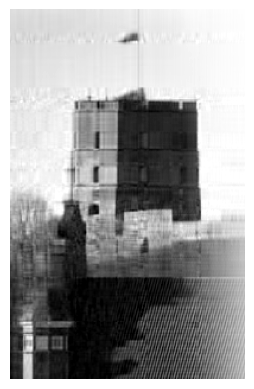

In [138]:
plot(model(X).numpy() + means)

Result looks really similar to what we get from SVD. What have we learned here? 

We have just performed a matrix decomposition, since $X \approx X W^T V^T$. Let's cite from Neural Networks and Deep Learning, a textbook by Chrau C. Aggarwal:

> Note that the autoencoder creates the reconstructed representation $D W^T V^T$ of the original data matrix. Therefore, it tries to optimize the problem of minimizing $||DW^T V^T − D||^2$. The optimal solution to this problem is obtained when the matrix $W$ contains the pseudo-inverse of $V$.

Let's check this statement

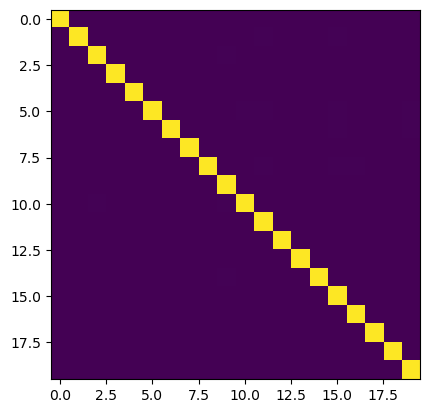

In [14]:
W = model.layers[0].weights[0].numpy()
A = model.layers[1].weights[0].numpy()

plt.imshow(A.dot(W))
plt.show()

**TASK:** let's go back to SVD lecture and Olivetti faces (`sklearn.datasets.fetch_olivetti_faces`) anomaly detection problem - flip one or couple of images upside down so that they would look like anomalies, then encode and decode. Use slightly deeper NN for anomaly detection and show that it produces more powerfull detector than PCA.

### Word2Vec & CNN's

Word2Vec is built using autoencoders and allows to convert words to vectors which have some semantic meaning. Some applications of these vectors might be stunning, for example:

<img width=50% src="http://jalammar.github.io/images/word2vec/king-analogy-viz.png"/>

To use pre-trained model we will use Spacy library (install it using `pipenv install spacy`). Then download the model by running `python -m spacy download en_core_web_md`. Remeber that you can run shell commands in notebook by adding `!`.

From here you can get embeddings as follows.

In [140]:
# !python -m spacy download lt_core_news_md

In [153]:
import spacy

nlp = spacy.load('lt_core_news_md')
sentance = nlp("katė šuo")
embeddings = np.array([word.vector for word in sentance])
embeddings.shape

(2, 300)

It is interesting to explore word reconstructions by mapping it to vector, performing some operations and going back using a distance measure. You can find more neat examples and high level explanation of Word2Vec in a book [The Alignment Problem](https://www.goodreads.com/en/book/show/50489349-the-alignment-problem).

To have more fun examples you will have to use much bigger model. Install gensim using `!pip install gensim` and download [model file](https://code.google.com/archive/p/word2vec/#:~:text=GoogleNews%2Dvectors%2Dnegative300.bin.gz) which is 1.5G. Then play with it, for example

```python
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
model.most_similar_cosmul(positive=['king', 'woman'], negative=['man'])

>> [('queen', 0.9314123392105103),
>>  ('monarch', 0.858533501625061),
>>  ('princess', 0.8476566672325134), ...]

model.most_similar_cosmul(positive=['fish', 'music'])

>> [('bass', 0.5192274451255798),
>>  ('catfish', 0.5176859498023987),
>>  ('trout', 0.5006918907165527), ...]
```

In [30]:
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=-------------------------------------------------] 3.8% 63.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 10.3% 171.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======--------------------------------------------] 12.1% 201.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======--------------------------------------------] 14.0% 232.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 23.5% 391.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 25.3% 421.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 32.0% 531.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 33.7% 560.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.5% 589.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 36.1% 601.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 38.7% 643.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 40.5% 672.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 42.4% 704.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 44.2% 735.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 46.2% 767.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================--------------------------] 48.5% 806.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 51.2% 851.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 66.6% 1107.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 67.7% 1125.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.8% 1143.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================================---------------] 70.3% 1169.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 72.0% 1197.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 73.7% 1225.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================================-------------] 75.4% 1254.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 77.2% 1283.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 78.8% 1311.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================================----------] 80.6% 1340.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 82.1% 1365.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 83.2% 1383.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 84.0% 1396.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 93.3% 1551.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 94.4% 1569.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.4% 1587.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [31]:
model.most_similar_cosmul(positive=['king', 'woman'], negative=['man'])   # king - man + woman = queen

[('queen', 0.9314123392105103),
 ('monarch', 0.858533501625061),
 ('princess', 0.8476566672325134),
 ('Queen_Consort', 0.8150269985198975),
 ('queens', 0.8099815249443054),
 ('crown_prince', 0.808997631072998),
 ('royal_palace', 0.8027306795120239),
 ('monarchy', 0.8019613027572632),
 ('prince', 0.800979733467102),
 ('empress', 0.7958388328552246)]

In [37]:
model.most_similar_cosmul(positive=['paris', 'spain'], negative=['france'])

[('madrid', 0.8418088555335999),
 ('dubai', 0.8352458477020264),
 ('heidi', 0.8218225240707397),
 ('lohan', 0.8193089365959167),
 ('paula', 0.8185458779335022),
 ('britney', 0.8145740032196045),
 ('portugal', 0.8145568370819092),
 ('alex', 0.8132041692733765),
 ('costa', 0.8125410676002502),
 ('florence', 0.8121743202209473)]

In [42]:
model.most_similar_cosmul(positive=['roof', 'castle'], negative=['house'])

[('spire', 0.8677828311920166),
 ('dome', 0.8600829243659973),
 ('turrets', 0.8587723970413208),
 ('crenelated', 0.8557136654853821),
 ('spiers', 0.8545315265655518),
 ('bell_tower', 0.8510499000549316),
 ('crenellations', 0.8497854471206665),
 ('campanile', 0.8468117713928223),
 ('domed', 0.8448273539543152),
 ('flying_buttresses', 0.8436140418052673)]

In [43]:
model.most_similar_cosmul(positive=['knee', 'arm'], negative=['leg'])

[('shoulder', 0.8514087200164795),
 ('elbow', 0.8418511748313904),
 ('surgically_repaired', 0.8303367495536804),
 ('forearm', 0.8242732286453247),
 ('rotator_cuff', 0.8171960115432739),
 ('wrist', 0.8161568641662598),
 ('elbow_ligament', 0.8117757439613342),
 ('surgically_repaired_knee', 0.8087441325187683),
 ('ankle', 0.8013917803764343),
 ('biceps', 0.7907865047454834)]

In [54]:
model.most_similar_cosmul(positive=['bride', 'man'], negative=['woman'])

[('groom', 0.8478626012802124),
 ('bridegroom', 0.8317368626594543),
 ('groomsmen', 0.8246725797653198),
 ('groomsman', 0.7922314405441284),
 ('wedding', 0.7913592457771301),
 ('Mohammad_Rassool_cousin', 0.7825929522514343),
 ('bestman', 0.7730644941329956),
 ('Groomsman', 0.7628263831138611),
 ('Groomsmen', 0.7602482438087463),
 ('fiance', 0.7579715847969055)]

In [44]:
model.most_similar_cosmul(positive=['doctor', 'woman'], negative=['man'])

[('gynecologist', 0.9882153868675232),
 ('nurse_practitioner', 0.9429976940155029),
 ('nurse', 0.9373465776443481),
 ('ob_gyn', 0.9323367476463318),
 ('doctors', 0.9288290739059448),
 ('pediatrician', 0.9242749810218811),
 ('obstetrician', 0.9175830483436584),
 ('physician', 0.9160466194152832),
 ('midwife', 0.9073526263237),
 ('nurse_midwife', 0.9057160019874573)]

In [48]:
model.most_similar_cosmul(positive=['politics', 'woman'], negative=['man'])

[('Politics', 0.8753053545951843),
 ('political', 0.8647885918617249),
 ('partisan_politics', 0.8531237244606018),
 ('feminism', 0.8180195689201355),
 ('feminist', 0.8147555589675903),
 ('politicians', 0.813095211982727),
 ('politcs', 0.8110021352767944),
 ('commentator_Minoru_Morita', 0.7975637912750244),
 ('Lisa_Vorderbrueggen_covers', 0.7966701984405518),
 ('feminist_theology', 0.7942215800285339)]

As you might expect these vectors can be used while creating the model, for example we can make sentiment analysis model for reviews (trying to figure out if it is positive or negative) simply by feeding embedding to CNN.

<img width=60% src="https://datasciencetoday.net/images/CNN.png"/>

**TASK:** using data from [imdb reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) train simple CNN based sentiment classifier.

## Mimics

If you ever need to compress the model due to some hardware or inference time constraints there is a simple trick that can help. Called mimic or teacher-student network, the idea is to train simpler model to do the same thing that a bigger model does. It is achieved by:
1. Creating a big and good model (can be an ensemble of models) that outputs softmax probabilities.
2. Pass a bunch of unlabeled examples via this teacher network and store his outputs.
3. Use these outputs to train a smaller model. You don't even need original training data now.
Try to think of the reasons why this trick works well. For more details see [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531) and [Do Deep Nets Really Need to be Deep?](https://arxiv.org/abs/1312.6184).

**TASK:** even though we do not have unlabeled data in flatland's project, try out mimic approach on your best model to see if you can reduce size without loosing too much accuracy.

## Mixup

Another cool idea is to mix two images and their classes into one and use such embedded image as a training example. For example, if we take MNIST, then we can randomly pick two different numbers and fuse images $A$ and $B$ by constructing their linear combination $\lambda A + (1 - \lambda) B$. Doing the same for their classes gives us the expected outcome that is used for training $\lambda y_A + (1 - \lambda) y_B$. For more details see [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412).

Both Mimics (Knowladge Distilation) and Mixup are frequently used tricks (see [bag of tricks paper](https://arxiv.org/abs/1812.01187)).

**TASK:** test this out on MNIST or flatland project.

## Permutation Feature Importance

Sometime you want to know which feature is most valuable. As we saw with Random Forests it can be done knowing how the algorithm is constructed. On the other hand it is useful to have a model agnostic approach that can be used without thinking about the model itself. Principle of permutation importance is quite simple - just shuffle a single column and measure the loss in accuracy. While estimating importance it's a good practice to use test set. Idea is explored in paper "All models are wrong, but many are useful: ..." by Fisher, Rudin, and Dominici (2018). Even though it's quite trivial to implement on your own you might find [scikit-learn implementation](https://scikit-learn.org/stable/modules/permutation_importance.html) useful.